<a href="https://colab.research.google.com/github/SambhaviPD/droughtwatch/blob/main/Drought_Prediction_Iteration_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drought Prediction : Public Benchmarking from Weights & Biases
To know more about the project goal, please refer to: https://wandb.ai/site/articles/droughtwatch

#Import required libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import random
import glob
import os
import time
import copy
from pathlib import Path
from itertools import chain
from collections import Counter

# pytorch related imports
import random

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm

In [ ]:
print("PyTorch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch version:  1.8.1+cu101
Torchvision version:  0.9.1+cu101


# Clone the droughtwatch repo from wandb & download the data set.

In [ ]:
# Initial setup per Readme in https://github.com/wandb/droughtwatch

# clone the repository
!git clone https://github.com/wandb/droughtwatch.git

# install wandb
!pip install wandb

%cd droughtwatch

# Download train and validation data
!bash download_data.sh

Cloning into 'droughtwatch'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 113 (delta 0), reused 1 (delta 0), pack-reused 110
Receiving objects: 100% (113/113), 7.52 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (55/55), done.
     |████████████████████████████████| 2.1MB 7.8MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 133kB 35.1MB/s 
     |████████████████████████████████| 163kB 32.6MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=74477711f18d259c8849ff638b8e97c598da8571e0d33a761e02875871bf14a8
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=bb1e3958c147256f2d5260b7e70625c4

#Configure folder paths

In [ ]:
# Common configuration parameters
train_data_path = 'data/train'
val_data_path = 'data/val'
test_data_path = 'data/test'
data_path = 'data'
folder_path = 'content/droughtwatch'

# Label names

In [ ]:
label_names = ['0', '1', '2', '3' ]

In [ ]:
# Create folder structure for train
for label in label_names:
  if not os.path.isdir(str(os.path.join(train_data_path, Path(label)))):
    os.makedirs(str(os.path.join(train_data_path, Path(label))))
  else:
    print('{} already exists!'.format(str(os.path.join(train_data_path, Path(label)))))

# Create folder structure for val
for label in label_names:
  if not os.path.isdir(str(os.path.join(val_data_path, Path(label)))):
    os.makedirs(str(os.path.join(val_data_path, Path(label))))
  else:
    print('{} already exists!'.format(str(os.path.join(val_data_path, Path(label)))))

# Training folders path

In [ ]:
t0 = os.path.join(train_data_path, label_names[0])
t1 = os.path.join(train_data_path, label_names[1])
t2 = os.path.join(train_data_path, label_names[2])
t3 = os.path.join(train_data_path, label_names[3])

# Validation folders path

In [ ]:
v0 = os.path.join(val_data_path, label_names[0])
v1 = os.path.join(val_data_path, label_names[1])
v2 = os.path.join(val_data_path, label_names[2])
v3 = os.path.join(val_data_path, label_names[3])

In [ ]:
# Data loading functions

# Function that returns files starting with part-r pattern from folder_path
def filelist(folder_path):
  files = Path(folder_path).glob('**/part-r-*')
  print('Number of TFRecordDatasets in {}: {}'.format(folder_path, len(os.listdir(folder_path))))
  return files

def load_data(data_path):
  train = filelist(train_data_path)
  val = filelist(val_data_path)
  return train, val

# Function that parses TFRecordDataset and returns individual records from the Dataset
def parse_file(file):
  filename = tf.data.TFRecordDataset(str(file))
  # TO DO: change make_one_shot_iterator to tf.v2 version
  iterator = tf.compat.v1.data.make_one_shot_iterator(filename)
  
  features = {
    'B1': tf.io.FixedLenFeature([], tf.string),
    'B2': tf.io.FixedLenFeature([], tf.string),
    'B3': tf.io.FixedLenFeature([], tf.string),
    'B4': tf.io.FixedLenFeature([], tf.string),
    'B5': tf.io.FixedLenFeature([], tf.string),
    'B6': tf.io.FixedLenFeature([], tf.string),
    'B7': tf.io.FixedLenFeature([], tf.string),
    'B8': tf.io.FixedLenFeature([], tf.string),
    'B9': tf.io.FixedLenFeature([], tf.string),
    'B10': tf.io.FixedLenFeature([], tf.string),
    'B11': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
  }

  parsed_files = [tf.io.parse_single_example(data, features) for data in iterator]
  return parsed_files

# Insall WandB

In [ ]:
%%capture
!pip install wandb --upgrade

# Import and Login to WandB

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Save TFRecordDataset records to .jpg files in order to proceed with
# Pytorch's data loaders. TO DO: (1) Needto save the images to google drive
# and mount the drive here and proceed rather than executing this
# every time. For the moment proceeding as is.
# (2) Need to see how to manipulate with TFRecordDataset itself. 
# Common configuration parameters
train, val = load_data(data_path)
train_files = []
val_files = []

#%cd 'data/train'
for file in train:
  #print(os.path.basename(file))
  parsed_train_files = parse_file(file)
  train_files.append(parsed_train_files)

for file in val:
  parsed_val_files = parse_file(file)
  val_files.append(parsed_val_files)

print(len(train_files))

Number of TFRecordDatasets in data/train: 405
Number of TFRecordDatasets in data/val: 105
400


Frequency of unique values:
[[    0     1     2     3]
 [51814 12851 13609  8043]]


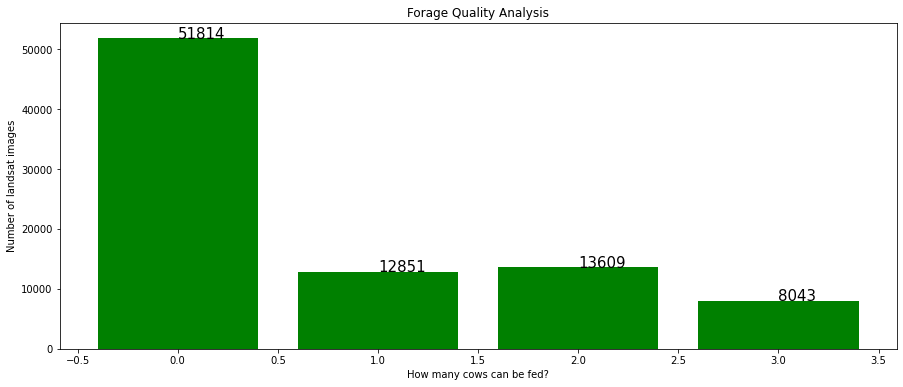

In [ ]:
# Temporary block
# Fetch labels from parsed_files
train_labels = np.array([])
for records in train_files:
  labels = tf.cast([ record['label'] for record in records], tf.int32).numpy()
  if train_labels.size == 0:
    train_labels = np.array([labels])
  else:
    train_labels = np.append(train_labels, [labels])

# Calculate unique labels and count of each in entire train folder
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print("Frequency of unique values:")
print(np.asarray((unique_elements, counts_elements)))

# Plot a bar chart to show data split 
figure = plt.figure(figsize=(15, 6))
plt.title('Forage Quality Analysis')
plt.xlabel('How many cows can be fed?')
plt.ylabel('Number of landsat images')
plt.bar(unique_elements, counts_elements, color='green')

# To display count of each label
for index, data in enumerate(counts_elements):
  plt.text(x=index, y=data+1, s=f'{data}', fontdict=dict(fontsize=15))
 
figure.show()

Frequency of unique values:
[[   0    1    2    3]
 [6443 1710 1673  952]]


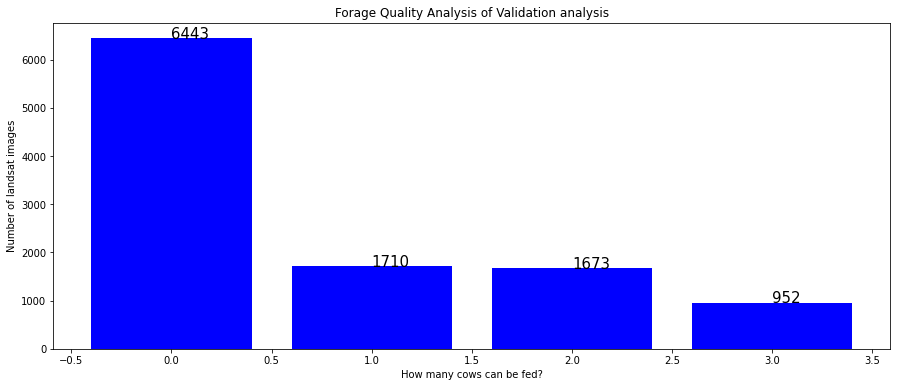

In [ ]:
# Temporary block
# Fetch labels from parsed_files - validation data set
val_labels = np.array([])
for records in val_files:
  labels = tf.cast([ record['label'] for record in records], tf.int32).numpy()
  if val_labels.size == 0:
    val_labels = np.array([labels])
  else:
    val_labels = np.append(val_labels, [labels])

# Calculate unique labels and count of each in entire train folder
unique_elements, counts_elements = np.unique(val_labels, return_counts=True)
print("Frequency of unique values:")
print(np.asarray((unique_elements, counts_elements)))

# Plot a bar chart to show data split 
figure = plt.figure(figsize=(15, 6))
plt.title('Forage Quality Analysis of Validation analysis')
plt.xlabel('How many cows can be fed?')
plt.ylabel('Number of landsat images')
plt.bar(unique_elements, counts_elements, color='blue')

# To display count of each label
for index, data in enumerate(counts_elements):
  plt.text(x=index, y=data+1, s=f'{data}', fontdict=dict(fontsize=15))
 
figure.show()

In [ ]:
# One off time
def get_image_from_example(parsed_example, intensify=True):
  rgbArray = np.zeros((65, 65, 3), 'uint8')
  for i, band in enumerate(['B5', 'B6', 'B7']):
    band_data = np.frombuffer(parsed_example[band].numpy(), dtype=np.uint8)
    band_data = band_data.reshape(65, 65)
    if intensify:
      band_data = band_data/np.max(band_data)*255
    else:
      band_data = band_data*255
    rgbArray[..., i] = band_data

  label = tf.cast(parsed_example['label'], tf.int32).numpy()

  return rgbArray, label

# Move files from train folder to appropriate folder based on the label of each file

In [ ]:
# One off time
import shutil

# Save files from train as images
cnt = 0
for records in train_files:
  for record in records:
    img, label = get_image_from_example(record)
    filename = 'image-' + str(cnt) + '-label '+ str(label) + '.jpg'
    plt.imsave(filename, img, cmap='gray')
    # Move files to appropriate folders based on their labels
    if label == 0:
      shutil.move(filename, t0)
    elif label == 1:
      shutil.move(filename, t1)
    elif label == 2:
      shutil.move(filename, t2)
    elif label == 3:
      shutil.move(filename, t3)
    else:
      print('Incorrect label')
    cnt += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


#Move files from val folder to appropriate folder based on the label of each file

In [ ]:
# Save files from val as images
cnt = 0
for records in val_files:
  for record in records:
    img, label = get_image_from_example(record)
    filename = 'image-' + str(cnt) + '-label '+ str(label) + '.jpg'
    plt.imsave(filename, img, cmap='gray')
    # Move files to appropriate folders based on their labels
    if label == 0:
      shutil.move(filename, v0)
    elif label == 1:
      shutil.move(filename, v1)
    elif label == 2:
      shutil.move(filename, v2)
    elif label == 3:
      shutil.move(filename, v3)
    else:
      print('Incorrect label')
    cnt += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
config = dict(
    num_epochs = 50,
    classes = 5,
    kernels = [16,16],
    batch_size = 64,
    learning_rate = 0.0003,
    dataset = 'droughtwatch-TFRecordDataset',
    architecture = 'resnet152-transfer-learning',
    feature_extract = True,
    momentum = 0.9,
    model_name = 'resnet-152',
    use_pretrained = True,
)

In [ ]:
# Define model pipeline
def model_pipeline(hyperparameters):
  # tell wandb to get started
  with wandb.init(project="droughtwatch-iteration 2", config=hyperparameters):
    # access all hyperparameters through wandb.config, so that logging matches execution
    config = wandb.config

    # make the model, data and optimization parameters
    model, dataloaders, criterion = make(config)

    # final step for finetuning and feature extracting is to create 
    # an optimizer that only updates the desired parameters
    optimizer = create_optimizer(model, config.feature_extract, config.learning_rate, config.momentum)

    # and use them to train model
    train(model, dataloaders, criterion, optimizer, config)

    # and test it's final performance
    #test(model, dataloaders['val'])

  return model

In [ ]:
def make(config):
  # make the model - TO DO: will change model details in a bit
  # model = ConvNet(config.kernels, config.classes).to(device)
  model_ft, input_size = initialize_model(config.model_name, config.classes, config.feature_extract, 
                                          use_pretrained=config.use_pretrained)
  # Make the data
  dataloaders = get_data(input_size, config.batch_size)

  # Make the loss and optimizer
  criterion = nn.CrossEntropyLoss()

  return model_ft, dataloaders, criterion

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
  model_ft = None
  input_size = 0

  if model_name == "densenet":
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    print('num_ftrs: ', num_ftrs)
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    input_size = 224
  elif model_name == "squeezenet":
    """ Squeezenet
    """
    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model_ft.num_classes = num_classes
    input_size = 224
  elif model_name == "resnet-152":
    # Resnet-152
    model_ft = models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
  else:
    print("Invalid model name, exiting...")
    exit()

  return model_ft, input_size

In [ ]:
def get_data(input_size, batch_size):
  # Data Augmentation and normalization for Training
  # Just normalization for Validation
  data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(input_size),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'val': transforms.Compose([
          transforms.Resize(input_size),
          transforms.CenterCrop(input_size),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }

  print('Initializing Datasets and DataLoaders...')

  # Create training and validation datasets
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x]) for x in ['train', 'val']}

  # Create training and validation dataloaders
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                shuffle=True, num_workers=0) for x in ['train', 'val']}

  print(dataloaders)    
  print(type(dataloaders))                                         

  return dataloaders

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.set_parameter_requires_grad = False

In [ ]:
def create_optimizer(model_ft, feature_extract, learning_rate, momentum):
  # Gather the parameters to be optimized/updated in this run. If we are
  # finetuning we will be updating all parameters. However, if we are
  # doing feature extract method, we will only update the parameters
  # that we have just initialized, i.e. the parameters with requires_grad
  # is True.
  
  # Send the model to device
  model_ft = model_ft.to(device)
  params_to_update = model_ft.parameters()
  print('Params to learn')
  if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
      if param.requires_grad == True:
        params_to_update.append(param)
        print('\t', name)
  else:
    for name, param in model_ft.named_parameters():
      if param.requires_grad == True:
        print('\t', name)

  # Observe that all parameters are optimized
  optimizer_ft = optim.SGD(params_to_update, lr=learning_rate, momentum=momentum)

  return optimizer_ft

In [ ]:
# Method to handle training and validation of a given model
def train(model, dataloaders, criterion, optimizer, config):
  # tell wandb to watch what the model gets upto: gradients, weights and more!
  # wandb.watch(model, criterion, log="all", log_freq=10)

  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(config.num_epochs):
    print("Epoch - {} / {}".format(epoch, config.num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ["train", "val"]:
      if phase == "train":
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      print('phase: {}, device: {}'.format(phase, device))
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase=="train"):
          # get model outputs and calculate loss
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          # backward and optimize only for training phase
          if phase == "train":
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      
      # Report metrics to wandb
      if phase == "train":
        wandb.log({"epoch": epoch, "train_loss": epoch_loss, "train_acc": epoch_acc})
      if phase == "val":
        wandb.log({"epoch": epoch, "val_loss":epoch_loss, "val_acc": epoch_acc})

      # deep copy the model
      if phase == "val" and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == "val":
        val_acc_history.append(epoch_acc)

      print()

  print("Best Val Accuracy: {:.4f}".format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)

  # Save the model
  torch.save(model.state_dict(best_model_wts), "resnet-152-weights-75epoch.pt")

  return model, val_acc_history

# Predict method
ToDo: Need to add images for test

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def test(model, dataloaders):
  model.eval()

  # Run the model on some test examples
  with torch.no_grad():
    correct, total = 0, 0
    for images, labels in dataloaders['test']:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      print(f"Accuracy of the model on the {total} " +
            f"test images: {100 * correct/total}%")
      
      wandb.log({"test accuracy": correct/total})

  # Plot the confusion matrix
  truelabels = []
  predictions = []
  for images, labels in dataloaders["test"]:
    images, labels = images.to(device), labels.to(device)
    for label in labels.cpu().data.numpy():
      truelabels.append(label)
    for prediction in model(images).data.cpu().numpy().argmax(1):
      predictions.append(prediction)

  cm = confusion_matrix(truelabels, predictions)
  tick_marks = np.arange(len(labels))

  df_cm = pd.DataFrame(cm, index = flower_labels, columns = flower_labels)
  plt.figure(figsize = (7,7))
  sns.heatmap(df_cm, annot=True, cmap=plt.cm.summer, fmt='g')
  plt.xlabel("Predicted value", fontsize = 20)
  plt.ylabel("True value", fontsize = 20)
  plt.show()

In [ ]:
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)

NameError: ignored